In [1]:
#Author: Vlada Krainikova 

## Стивен Кинг и его пасхалки

Основной датасет взят с Kaggle: https://www.kaggle.com/ttalbitt/stephen-king-books

С единственной поправкой: к нему был добавлен текст Томминокеров, т.к. это последняя прочитанная мной книга "короля", а потому  отслеживать работу алгоритмов на ее примере было удобно и быстро.


Первым делом импортировали главные библиотеки, из интересного здесь:
* zipfile - для работ с архивами, если вы как и я цените каждый свободный байт.
* nltk - банально, но эффективно для работы с NLP задачами.
* spicy - еще одна NLP библиотека в акцентом на извлечение именнованных сущностей.
* regex (re) - с текстом работаем? работаем. значит, без регулярок не обойтись
* networkx - для построения сетевх графов


In [2]:
import pandas as pd
import numpy as pt
import zipfile

import nltk
import re

import spacy
import en_core_web_lg

import networkx as nx

In [3]:
myzipfile= zipfile.ZipFile('archive.zip', 'r')

#длина романа
for name in myzipfile.namelist():
    text=myzipfile.open(name).read().decode('utf-8')
    print(name, len(text))


Stephen_King_TheLittleSistersOfEluria.txt 121555
Stephen_King_TheShining.txt 859274
Stephen_King_TheTommyknockers.txt 1417868
Stephen_King_TheWasteLands.txt 913165
Stephen_King_WizardAndGlass.txt 1351766
Stephen_King_BagOfBones.txt 1034192
Stephen_King_BlackHouse.txt 1245485
Stephen_King_Carrie.txt 294554
Stephen_King_It.txt 2229972
Stephen_King_Misery.txt 588035
Stephen_King_SalemsLot.txt 800623
Stephen_King_SongOfSusannah.txt 664910
Stephen_King_TheDarkTower.txt 1444484
Stephen_King_TheDeadZone.txt 789723
Stephen_King_TheDrawingOfTheThree.txt 660879
Stephen_King_TheGirlWhoLovedTomGordon.txt 325769
Stephen_King_TheGunslinger.txt 300927


In [4]:
#Сначала попробуем достать, что хотели, хотя бы из одного романа, например, недавно прочитанного: Томминокеров
tommynokers=myzipfile.open('Stephen_King_TheTommyknockers.txt').read().decode('utf-8')


In [5]:
#!python -m spacy download en_core_web_lg - не забудьте установить себе модель!
nlp = en_core_web_lg.load()
nlp.max_length = 2500000
doc = nlp(tommynokers)

### Извлечем имена всех персонажей

Во-первых, узнаем, кто же все-таки главный герой романа. Во-вторых, сможем соединить романы посредством упоминаемых персонажей.

Для этого взяли билиотеку SpaCy (и nltk неплохо справлялся), но SpaCy:
а) распознала чуть больше человеков
б) была удобнее для обработки результатов

Как сделали:
1. Извлекли все, что "PERSON"
2. Убрали 's (можно назвать примитивной лемматизацией)
3. Также убрали Mrs, Mr, Ms, но решили не убирать Dr
4. Все имена состоящие менее, чем из двух слов (например, Бобби или Гарденер).

In [6]:
#Сначала достанем людей (персонажей)
persons = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']

In [7]:
#Почистим: уберем Mrs, Miss, Ms, Mister, Mr, "'s" и стоп слова
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

index_to_delete=[]
list_of_p=persons[0:len(persons)]
for i in range(len(list_of_p)):
    list_of_p[i]=re.sub(r'\'s','',list_of_p[i])
    list_of_p[i].strip()
    list_of_p[i]=re.sub(r'Mrs|Mr|Ms','',list_of_p[i]).strip()
    if re.findall(r'[^a-zA-Z_ ]',list_of_p[i])!=[]:
        index_to_delete.append(i)
    elif len(re.split('\W',list_of_p[i]))<2:
        index_to_delete.append(i)
    else:
        for word in re.split('\W',list_of_p[i]):
            if word in stopwords:
                list_of_p[i]=re.sub(word,'',list_of_p[i])
                
        
for index in sorted(index_to_delete, reverse=True):
    del list_of_p[index]

unique_char=list(set(list_of_p))

In [8]:
freq=[]
for i in unique_char:
    freq.append(list_of_p.count(i))
characters=pd.DataFrame(unique_char,columns=['character'])
characters['freq']=freq
characters['novel']='TheTommyknockers'
characters.sort_values(by='freq',ascending=False)    

,character,freq,novel
33,Bobbi Anderson,83,TheTommyknockers
91,David Brown,53,TheTommyknockers
0,Jim Gardener,49,TheTommyknockers
251,Ruth McCausland,46,TheTommyknockers
191,Dick Allison,33,TheTommyknockers
...,...,...,...
164,Robert Young,1,TheTommyknockers
162,Pat Summerall,1,TheTommyknockers
161,Clive Cussler,1,TheTommyknockers
160,Anne lay sleepless,1,TheTommyknockers


Главный герой томминокеров все-таки Бобби Андерсон. А Джим даже не 2 месте. Однако, чтобы результаты были совсем честными в подсчете стоит учитывать отдельно упоминаемые фамилии и имена (которые мы выкинули) и разные формы (Джим Гарденер, Джеймс Гарденер и т.д.).
Это все можно сделать (разбив на имя и фамилию), но пока для первоначальной идеи поиска пасхалок нам это не требуется.

**Соберем же наконец персонажей всех романов и посмотрим**

In [9]:
all_characters = pd.DataFrame(columns=['character','freq','novel'])
for name in myzipfile.namelist():
    text=myzipfile.open(name).read().decode('utf-8')
    doc = nlp(text)
    persons = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']

    index_to_delete=[]
    list_of_p=persons[0:len(persons)]

    for i in range(len(list_of_p)):
        list_of_p[i]=re.sub(r'\'s','',list_of_p[i])
        list_of_p[i].strip()
        list_of_p[i]=re.sub(r'Mrs|Mr|Ms','',list_of_p[i]).strip()
        if re.findall(r'[^a-zA-Z_ ]',list_of_p[i])!=[]:
            index_to_delete.append(i)
        elif len(re.split('\W',list_of_p[i]))<2:
            index_to_delete.append(i)      
    for index in sorted(index_to_delete, reverse=True):
        del list_of_p[index]
    unique_char=list(set(list_of_p))

    freq=[]
    for i in unique_char:
        freq.append(list_of_p.count(i))
    characters=pd.DataFrame(unique_char,columns=['character'])
    characters['freq']=freq
    characters['novel']=re.split(r'\.',re.split(r'Stephen_King_',name)[1])[0]
    all_characters=all_characters.append(characters, ignore_index=True)

In [10]:
all_characters.head()


,character,freq,novel
0,Tamra Doffed,1,TheLittleSistersOfEluria
1,sai Roland,1,TheLittleSistersOfEluria
2,timesof Gilead,1,TheLittleSistersOfEluria
3,Im Roland,1,TheLittleSistersOfEluria
4,Oooo Sister Coquina,1,TheLittleSistersOfEluria


Настал момент истины: смотрим, кто из "уважаемых" встречался в нескольких книгах.

Если не знать американскую культуру 70-80-х (что вполне простительно), то можно просматривать имена и удивляться насколько хорошо мы с вами сработали. И даже такие попадания, как "Mike Mike" (простое дублирование имени) или "Roland Eddie" (сочетание имен героев) не омрачают ваше счастье. Но длится оно все-таки недолго: 
1. На 10-й строчке вы встречаете Silva Compass - и нет, это не кличка очередного ребенка, а компания производящая... компасы.
2. На 13-й строчке фирменный хук с правой нашей логике дает Sherlock Holmes. "Элементарно" - кричите вы и понимаете, что сюда попали и другие знаменитые люди и персонажи: начиная с самого Шерлока, Шалтая болтая или Дональда Дака и заканчивая... Иисусом Христом (о его появлении мы еще поговорим).

Что делать? 
Можно было бы: настроить автоматическое обращение куда-то сюда (https://stephenking.fandom.com/ru/wiki/%D0%9A%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D1%8F:%D0%9F%D0%B5%D1%80%D1%81%D0%BE%D0%BD%D0%B0%D0%B6%D0%B8) или спарсить оттуда же сам лист персонажей и проверить, кто из наших героев в него входит, а кто остается за рамками.

Что было сделано: вручную (ну не только) отсмотрели все 117 имен и присвоили каждому наблюдению категорию. Распределение по категориям можно видеть ниже. 
Но почему? Потому что интересно! Интересно, кто такой Джон Дири, каких президентов любит/ненавидит, но упоминает Кинг, и какие в принципе люди/персонажи заслужили упоминания автора аж в нескольких книгах.

Например, Джон Дири - вовсе не персонаж, а фирма выпускающая сельхоз технику: тракторы. "Больше тракторов богу тракторов!"

In [11]:
k=set(list(all_characters.character))
p=list(all_characters.character)
for i in k:
    if p.count(i)>2:
        print(i, p.count(i))

Charlie the ChooChoo 3
Paul Harvey 3
Jake Susannah 3
Lyndon Johnson 3
Childe Roland 5
Lee Harvey Oswald 3
Jack Andolini 4
Jesus Christ 11
Susannah Roland 3
George Biondi 3
Sylvia Pittston 3
Max Brand 3
Jack Mort 5
Ake Oy 3
Elmer Chambers 4
Susannah Eddie 3
Phil Ochs 3
Beryl Evans 3
Fred Astaire 3
Eddie Deans 5
Detta Walker 5
Roland Eddie 5
John Henry 3
John Irving 3
Tom Sawyer 3
Thomas Wolfe 4
Donald Duck 3
Henry Dean 5
Marilyn Monroe 3
Eldred Jonas 4
Kurt Barlow 3
Odetta Holmes 4
Yul Brynner 3
Robert Brownings 3
Chuck Verrill 4
Marvin Gaye 4
Alain Johns 3
St Paul 3
Oy Roland 3
Greta Shaw 4
Nelson Rockefeller 3
Sherlock Holmes 5
Jerry Lee Lewis 3
Humpty Dumpty 3
sai Roland 3
Henry Henry 6
Mike Mike 3
Silva compass 3
Calvin Tower 3
Buck Rogers 3
Jake Chambers 5
Susannah Dean 4
Frank Sinatra 4
Martin Luther King 3
Roland Roland 5
Jake Roland 3
Eddie Jake 4
Jake Eddie 3
Aaron Deepneau 4
Walter Cronkite 4
Odetta Holmess 4
Raggedy Ann 3
Eddie Eddie 5
Eddie Susannah 3
Eddie Roland 5
Rube Gol

In [12]:
all_characters[(all_characters['character']=='John Deere')]

,character,freq,novel
524,John Deere,2,TheTommyknockers
2983,John Deere,1,BlackHouse
4413,John Deere,1,It
5858,John Deere,1,SalemsLot


In [13]:
mentions=pd.read_csv('Mentioned_cats.csv', sep = ';')
mentions.head()

,original,character_full_name,freq,who,name,surname
0,Jesus Christ 11,Jesus Christ,11,Jesus,Jesus,Christ
1,John Wayne 9,John Wayne,9,actor,John,Wayne
2,Richard Nixon 7,Richard Nixon,7,politician,Richard,Nixon
3,Robert Browning 6,Robert Browning,6,writer,Robert,Browning
4,Henry Henry 6,Henry Henry,6,dubler,Henry,Henry


Нас, конечно, интересуют только персонажи, но чтобы в случае чего мы могли посмотреть на связи за счет упоминания известных фигур, мы оставили и их.

Что делаем теперь: берем персонажей, извлекаем книги, в которых они упомянуты. Для каждой книги получаем: книгу-соседа и силу связи (кол-во упоминаемых персонажей).

In [14]:
mentioned_chars = list(mentions[(mentions['who']=='character')].character_full_name)

characters = all_characters[all_characters['character'].isin(mentioned_chars)].sort_values(by="character")


In [15]:
char_connections = pd.DataFrame(columns=['novel','neighbour','strength'])

k=sorted(list(set(all_characters.novel)))

for i in range (len(k)):
    for j in range (i + 1, len(k)):
        c=characters[(characters['novel']==k[i])|
                     (characters['novel'] == k[j])].groupby(by='character').count()
        s=len(c[(c['novel']>1)])
        char_connections.loc[len(char_connections)]=[k[i], k[j],s]

char_connections

,novel,neighbour,strength
0,BagOfBones,BlackHouse,0
1,BagOfBones,Carrie,0
2,BagOfBones,It,0
3,BagOfBones,Misery,0
4,BagOfBones,SalemsLot,0
...,...,...,...
131,TheShining,TheWasteLands,0
132,TheShining,WizardAndGlass,0
133,TheTommyknockers,TheWasteLands,0
134,TheTommyknockers,WizardAndGlass,0


In [16]:
G = nx.Graph()
for index, row in char_connections.iterrows():
    if row['strength']>0:
        G.add_edge(row['novel'],row['neighbour'],weight=row['strength'])
        
weights = nx.get_edge_attributes(G,'weight').values()
weights = [float(i)/max(list(weights)) for i in list(weights)]
pos = nx.spring_layout(G)

nx.draw(G,
        pos,
        with_labels=True, 
        width=list(weights))

import matplotlib.pyplot as plt

plt.savefig('before.png')
l,r = plt.xlim()
plt.xlim(l-0.2,r+0.2)
plt.savefig('after.png')


D:\Programs\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


Если с «Смиренные сёстры Элурии» (The Little Sisters of Eluria), «Стрелок» (The Gunslinger), «Извлечение троих» (The Drawing of the Three), «Бесплодные земли» (The Waste Lands), «Колдун и кристалл» (Wizard and Glass), «Песнь Сюзанны» (Song of Susannah) и 
самой «Тёмной башней» (The Dark Tower) все ясно и предсказуемо: все это книги цикла Темная башня, то связи с «Салимов Удел» (Salems Lot) и «Черный дом» (Black House) как раз то, к чему мы все это время шли: неочевидные отсылки, которые можно упустить, если не выписывать себе все имена.

Так, например, один из главных героев книги "Салемов удел", отец Каллагэн - второстепенный герой цикла «Темная Башня» (части: "Волки Кальи", "Песнь Сюзанны" и "Темная башня"). А "Черный дом"  

Что можно сделать дальше, как обнаружить больше пасхалок?
1. Можно посмотреть на локации, т.к. любой фанат Кинга может с лету назвать список городов и других мест "нежелательных для посещения" в силу происходящих там страстей: от Дерри до Хевена, через Оверлук и обратно. Действие некоторых романов и рассказов происходят в одной и той же местности (например, "Оно" или "Ловец Снов"), в других же просто может содержаться указатель на эти популярные места (например, Дорожный знак «На Салимов Удел» упоминается в «Оно», «Кладбище домашних животных», «Ловец снов» и «Волки Кальи»). 
2. Можно попробовать зайти с дат (если уж мы идем по именованным сущностям), т.к. действительно интересно могли ли события в разных книгах совпадать по времени. Однако извлечь полную дату из текста (день, меясц, год) будет тем еще испытанием.
3. Повышая уровень сложности, можно взглянуть на совпадения во фразах/присказках/пословицах. Эта идея пришла к нам, когда мы пытались объяснить связь "Салемова удела" с другими книгами и натолкнулись на интересный факт, что в «Оно» главный герой повторяет для самоконцентрации ту же поговорку, что и Марк Петри в «Салемов Удел».
4. Самое сложное: описание непосредственно событий. Читатели разных серий наверняка испытывали недюжее удовольствие, когда в очередной упомянутой вскольз истории распознавали отсылку на сюжет той или иной книги. У Кинга так же, вот только, как научить машину видеть такие неформализованные отсылки - очень интересный вопрос.

Кажется, что движение дальше по описанному плану: поиск географических, временных и других отсылок, не будет зависеть от того, зайдет эта статья или нет,но вот скорость "домашнего анализа" очень даже. Если у вас есть идеи, дополнения, комментарии, как и что можно сделать лучше/быстрее/просто сделать - делитесь, будеи интересно посмотреть на это вместе.


### P.S. Имена ... самих книг.
Я не стала выносить это в отдельную часть, ведь названия романов - это тоже своего рода имена, да и к тому же никакой магии анализа в этом нет: Ctrl+F и никакого мошеничества.
Эту идею я взяла на заметку во время чтения последней книги "Томминокеры", где Кинг, не стесняясь, дает ссылку на Сияние, хоть и экранизированное: "Grab Bobbi's ax and make like Jack Nicholson in The Shining?".

Смотрим, что вышло:

In [17]:
#Добавили пробелы
novel_names=[]
space=" "
for i in k:
    novel_names.append(space.join(re.findall(r'[A-Z][^A-Z]*',i)))


#It -- придется исключить по понятным причинам
novel_names.remove('It')

df=pd.DataFrame(columns=['what_novel_name','in_what_novel','mention'])
for name in myzipfile.namelist():
    text=myzipfile.open(name).read().decode('utf-8')
    space=" "
    new_name=space.join(re.findall(r'[A-Z][^A-Z]*',re.split(r'\.',re.split(r'Stephen_King_',name)[1])[0]))

    for i in novel_names:
        if i != new_name:
            x=re.findall(i,text)
            if x!=[]:
                for mention in x:
                     df.loc[len(df)]=[i,new_name,mention]
name_connections=df.groupby(by=['what_novel_name','in_what_novel']).count()
name_connections.reset_index( inplace=True)
name_connections.columns=['novel','neighbour','strength']
name_connections

,novel,neighbour,strength
0,Carrie,Song Of Susannah,2
1,Carrie,The Dark Tower,1
2,Carrie,The Dead Zone,1
3,Misery,The Dark Tower,2
4,Misery,The Tommyknockers,1
5,Salems Lot,Song Of Susannah,16
6,Salems Lot,The Dark Tower,1
7,Salems Lot,The Gunslinger,1
8,The Dark Tower,Song Of Susannah,18
9,The Dark Tower,The Drawing Of The Three,3


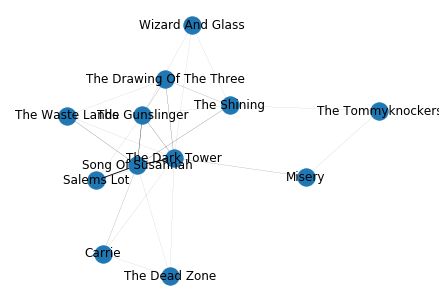

In [18]:
G = nx.Graph()
for index, row in name_connections.iterrows():
    if row['strength']>0:
        G.add_edge(row['novel'],row['neighbour'],weight=row['strength'])
        
weights = nx.get_edge_attributes(G,'weight').values()
weights = [float(i)/max(list(weights)) for i in list(weights)]
pos = nx.spring_layout(G)

nx.draw(G,
        pos,
        with_labels=True, 
        width=list(weights))

import matplotlib.pyplot as plt

plt.savefig('before.png')
l,r = plt.xlim()
plt.xlim(l-0.2,r+0.2)
plt.savefig('after.png')


Вышел неожиданный, но интересный граф! Из него видно, что сами романы упоминаются чаще, чем их герои. Конечно, получившаяся паутинка не идеальна: название романа "Стрелок" и "кличка" Роланда из Темной башни будут идентичны (the Gunslinger), Misery может быть как названием романа, так и простым отчаянием с большой буквы и т.д. И что же делать? Только с упоением читать романы и проверять самостоятельно, ведь этот анализ всего лишь прелюдия к главному удовольствию: чтению старой доброй страшной истории на ночь. 

"Если вам кажется, что я вас обманываю, значит, вы невнимательно слушали вечерние новости".

In [ ]:
#Author: Vlada Krainikova 